# Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

## Imports

In [38]:
# for image name
import random

# define and move to dataset and model directory
import os
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

# duplicate combined image to other directory and delete directory with its content
import shutil

#for stopping code if not the right amount of images
import sys

#histograph/confusion matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

#model creation
import tensorflow.keras as keras

import numpy as np

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#k-fold cross validation
import pandas as pd                                     #store all images and their class/label
from sklearn.model_selection import StratifiedKFold     
#from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split    #split the dataset to train-test
import tensorflow as tf                                 #for callbacks

#for model evaluation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#validating misclassified images
import cv2     #load the image

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
1,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
2,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
3,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
4,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
...,...,...
295,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
296,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
297,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
298,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2


In [4]:
print(df['label'].unique())

['0' '1' '2']


In [5]:
print(df.isna().any())

filename    False
label       False
dtype: bool


## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [6]:
## Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

Save the split sets to train and test set folders.

In [7]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [8]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
108,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
79,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
110,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
27,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
36,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
...,...,...
234,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
65,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
162,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
227,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2


## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the models

In [9]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 3,
    )

## Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [10]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

## Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [11]:
save_cur = ""  #check if there is any saved_models folders

svnum = 0
svnum2 = 0

for x in os.listdir(gen_dir):
    if "saved_models" in x:
        save_cur = x
        if not save_cur == "":
            for word in save_cur.split("_"):
                if word.isdigit():
                    svnum2 = int(word)
                    if svnum < svnum2:
                        svnum = svnum2
            

#save_dir is where the created models using the current set of parameters are added        
if save_cur == "":
    save_dir = gen_dir + "/saved_models_1"
    #print(save_dir)
    os.makedirs(save_dir)
else:
    save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
    #print(save_dir)
    os.makedirs(save_dir)

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [12]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in conv_model.layers:
    layer.trainable = False

"""
#print(conv_model.output_shape)
x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x) #to further reduce overfitting
"""
x = keras.layers.Flatten()(conv_model.output)
#x = keras.layers.Dense(256, activation='relu')(x)
#x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
#x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(0.2)(x) #to further reduce overfitting

predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Model Parameters

We will initialize the model parameters here so that it is easier to change when training multiple times to get the ideal results.

In [13]:
#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

#print(Y['label'].value_counts())
#print(Y['label'].unique())

#initialize parameters
VALIDATION_ACCURACY = []                          #store all validation_accuracy
VALIDATION_LOSS = []                              #store all validation_loss
image_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
batch_size = 8                                    #batch size
fold_var = 1                                      #number of fold of the model
n = len(df2)                                      #number of data in train set
num_epochs = 20                                   #number of epochs
dim = (224,224)                                   #required dimensions for process_unit (ResNet50)
lr = 0.00001                                      #learning rate Adamax

## Model Training

We will now train the model. K-fold cross validation is used to train the model.

Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Fold number 1
Epoch 1/20
27/27 [==============================] - 13s 282ms/step - loss: 1.1711 - accuracy: 0.4722 - val_loss: 0.9162 - val_accuracy: 0.5185

Epoch 00001: val_accuracy improved from -inf to 0.51852, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
27/27 [==============================] - 4s 160ms/step - loss: 0.8725 - accuracy: 0.5602 - val_loss: 0.8150 - val_accuracy: 0.5370

Epoch 00002: val_accuracy improved from 0.51852 to 0.53704, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 3/20
27/27 [==============================] - 4s 143ms/step - loss: 0.8805 - accuracy: 0.6111 - val_loss: 0.8360 - val_accuracy: 0.6111

Epoch 00003: val_accuracy improved from 0.53704 to 0.61111, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 4/20
27/27 [==============================] - 4s 138ms/step - loss: 0.7979 - accuracy: 0.6019 - val_loss: 0.7732 - val_accuracy: 0.6852

Epoch 00004: val_accuracy improved from 0.61111 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 5/20
27/27 [==============================] - 3s 125ms/step - loss: 0.7085 - accuracy: 0.6481 - val_loss: 0.6026 - val_accuracy: 0.7407

Epoch 00005: val_accuracy improved fro

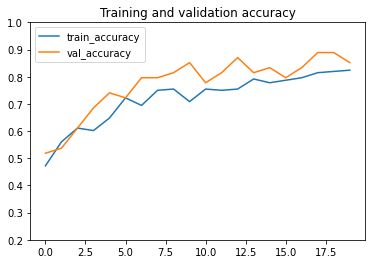

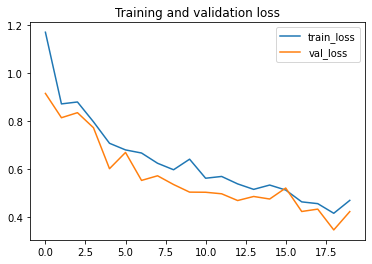

7/7 [==============================] - 1s 98ms/step - loss: 0.5129 - accuracy: 0.7778
{'loss': 0.5128586888313293, 'accuracy': 0.7777777910232544}
Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Fold number 2
Epoch 1/20
27/27 [==============================] - 9s 209ms/step - loss: 0.5442 - accuracy: 0.7824 - val_loss: 0.5194 - val_accuracy: 0.7407

Epoch 00001: val_accuracy improved from -inf to 0.74074, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 2/20
27/27 [==============================] - 4s 156ms/step - loss: 0.4551 - accuracy: 0.8287 - val_loss: 0.4605 - val_accuracy: 0.7778

Epoch 00002: val_accuracy improved from 0.74074 to 0.77778, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 3/20
27/27 [==============================] - 6s 216ms/step - loss: 0.3833 - accuracy: 0.8287 - val_loss: 0.5238 - val_accuracy: 0.6667

Epoch 00003: val_accuracy did not 

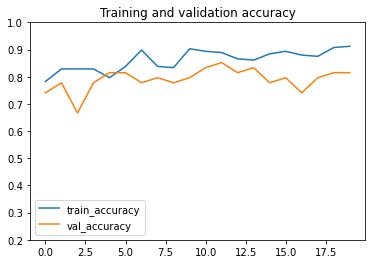

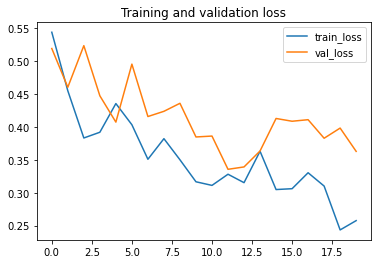

7/7 [==============================] - 1s 133ms/step - loss: 0.4072 - accuracy: 0.7778
{'loss': 0.40720805525779724, 'accuracy': 0.7777777910232544}
Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Fold number 3
Epoch 1/20
27/27 [==============================] - 10s 209ms/step - loss: 0.3915 - accuracy: 0.8380 - val_loss: 0.3994 - val_accuracy: 0.7778

Epoch 00001: val_accuracy improved from -inf to 0.77778, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_3.h5
Epoch 2/20
27/27 [==============================] - 7s 245ms/step - loss: 0.3314 - accuracy: 0.8565 - val_loss: 0.3139 - val_accuracy: 0.8519

Epoch 00002: val_accuracy improved from 0.77778 to 0.85185, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_3.h5
Epoch 3/20
27/27 [==============================] - 4s 145ms/step - loss: 0.3196 - accuracy: 0.8704 - val_loss: 0.2871 - val_accuracy: 0.9259

Epoch 00003: val_accuracy impro

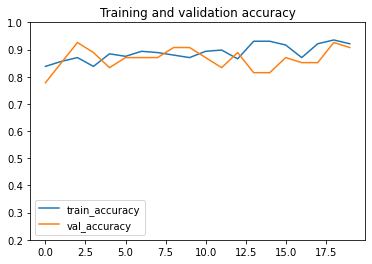

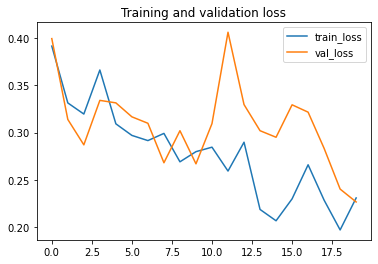

7/7 [==============================] - 1s 116ms/step - loss: 0.3204 - accuracy: 0.8889
{'loss': 0.320443332195282, 'accuracy': 0.8888888955116272}
Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Fold number 4
Epoch 1/20
27/27 [==============================] - 12s 303ms/step - loss: 0.4072 - accuracy: 0.8241 - val_loss: 0.3031 - val_accuracy: 0.8519

Epoch 00001: val_accuracy improved from -inf to 0.85185, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 2/20
27/27 [==============================] - 6s 198ms/step - loss: 0.3529 - accuracy: 0.8704 - val_loss: 0.2785 - val_accuracy: 0.9259

Epoch 00002: val_accuracy improved from 0.85185 to 0.92593, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 3/20
27/27 [==============================] - 5s 193ms/step - loss: 0.3523 - accuracy: 0.8519 - val_loss: 0.2307 - val_accuracy: 0.8889

Epoch 00003: val_accuracy did not

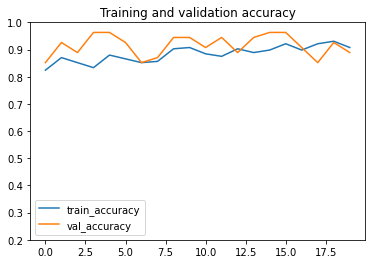

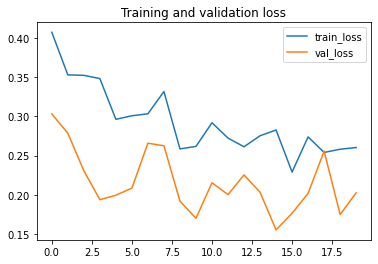

7/7 [==============================] - 1s 127ms/step - loss: 0.2289 - accuracy: 0.9074
{'loss': 0.228866308927536, 'accuracy': 0.9074074029922485}
Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Fold number 5
Epoch 1/20
27/27 [==============================] - 11s 265ms/step - loss: 0.3041 - accuracy: 0.8657 - val_loss: 0.3486 - val_accuracy: 0.8519

Epoch 00001: val_accuracy improved from -inf to 0.85185, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 2/20
27/27 [==============================] - 6s 213ms/step - loss: 0.3118 - accuracy: 0.8796 - val_loss: 0.2235 - val_accuracy: 0.9074

Epoch 00002: val_accuracy improved from 0.85185 to 0.90741, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 3/20
27/27 [==============================] - 6s 234ms/step - loss: 0.3214 - accuracy: 0.8611 - val_loss: 0.3160 - val_accuracy: 0.8889

Epoch 00003: val_accuracy did not

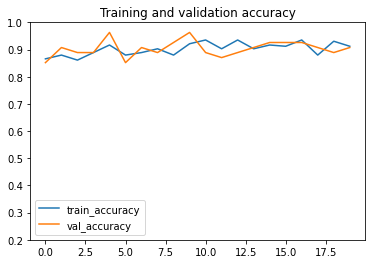

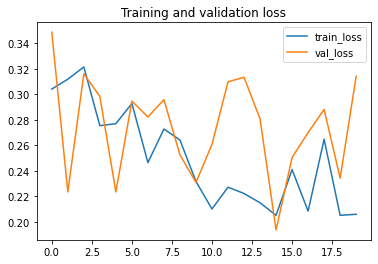

7/7 [==============================] - 1s 136ms/step - loss: 0.2936 - accuracy: 0.9074
{'loss': 0.2936333119869232, 'accuracy': 0.9074074029922485}


In [14]:
for train_index, val_index in skf.split(np.zeros(n),Y):
    
    training_data = df2.iloc[train_index]
    validation_data = df2.iloc[val_index]
    
    train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "filename", y_col = "label",
                              class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = False)
    valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = False)
    
    # COMPILE NEW MODEL
    full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=lr),
                  metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
   
    print("Fold number " + str(fold_var))

    # FIT THE MODEL
    history = full_model.fit(train_data_generator,
                             epochs=num_epochs,
                             callbacks=callbacks_list,
                             validation_data=valid_data_generator)
    
    #PLOT HISTORY
    plot_history(history, yrange=(0.2,1))

    # LOAD BEST MODEL to evaluate the performance of the model
    full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")
    
    results = full_model.evaluate(valid_data_generator)
    results = dict(zip(full_model.metrics_names,results))
    
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1    

## Kfold Evaluation Results

Below are the validation accuracy and validation loss per fold and their average.

In [15]:
print("Validation Accuracy of All Folds:")
n = 1
for x in VALIDATION_ACCURACY:
    print("Fold "+ str(n) +" Accuracy:",x)
    n=n+1    
print("Mean Validation Accuracy: " + str(np.mean(VALIDATION_ACCURACY)))

print("")

print("Validation Loss of All Folds:")
n=1
for x in VALIDATION_LOSS:
    print("Fold "+ str(n) +" Loss:",x)
    n=n+1    
print("Mean Validation Loss: " + str(np.mean(VALIDATION_LOSS)))

Validation Accuracy of All Folds:
Fold 1 Accuracy: 0.7777777910232544
Fold 2 Accuracy: 0.7777777910232544
Fold 3 Accuracy: 0.8888888955116272
Fold 4 Accuracy: 0.9074074029922485
Fold 5 Accuracy: 0.9074074029922485
Mean Validation Accuracy: 0.8518518567085266

Validation Loss of All Folds:
Fold 1 Loss: 0.5128586888313293
Fold 2 Loss: 0.40720805525779724
Fold 3 Loss: 0.320443332195282
Fold 4 Loss: 0.228866308927536
Fold 5 Loss: 0.2936333119869232
Mean Validation Loss: 0.3526019394397736


In [16]:
bobo

NameError: name 'bobo' is not defined

## Model Prediction and Evaluation

Load the images in the test set and predict what class it is by using the model. There are three values of confidence level. The one with the highest confidence level is the predicted class of the image. The order of classes is [0 1 2]. The results will be feed to the eval function defined below in order to get the metrics.

In [39]:
#Metrics
def eval(yhat_probs, yhat_classes):
    #make the labels to integer to get the model metrics
    yt = pd.to_numeric(y_test['label'])

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(yt, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes, average="weighted")
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes, average="weighted")
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt, yhat_classes, average="weighted")
    print('F1 score: %f' % f1)
    # ROC AUC
    #auc = roc_auc_score(yt, yhat_probs)
    #print('ROC AUC: %f' % auc, average="weighted")
    
    #ROC AUC
    #-------------------------------------------------------------------------------
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    #print(y)
    #print(n_classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytbin.ravel(), yhat_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Balut-Penoy')
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Salted Egg')
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Table Egg')
    plt.legend(loc="lower right")
    plt.show()
    #-------------------------------------------------------------------------------
    
    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes)
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

fold 1metrics:
Accuracy: 0.900000
Precision: 0.900000
Recall: 0.900000
F1 score: 0.900000


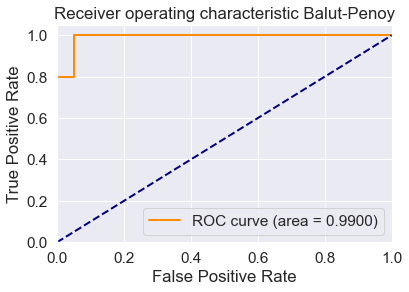

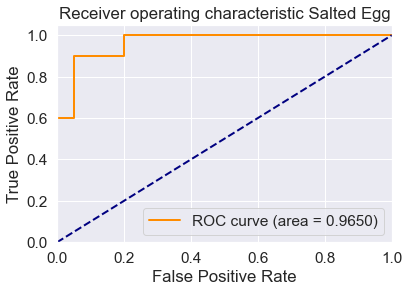

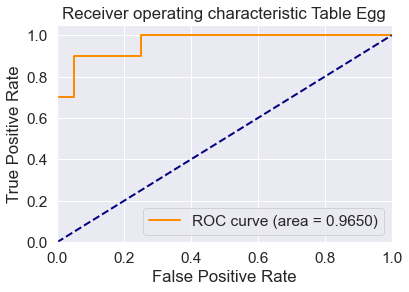

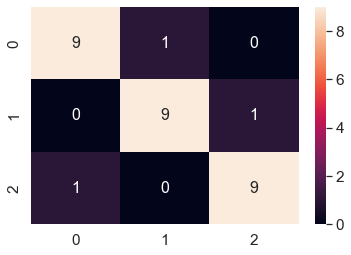


fold 2metrics:
Accuracy: 0.866667
Precision: 0.869024
Recall: 0.866667
F1 score: 0.866416


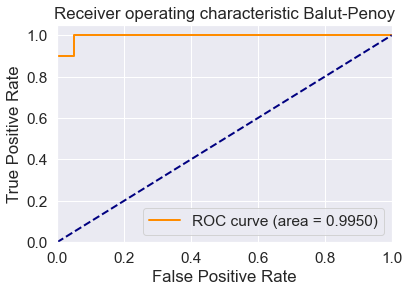

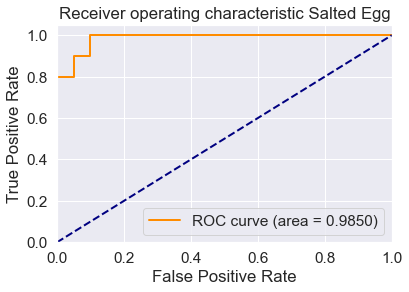

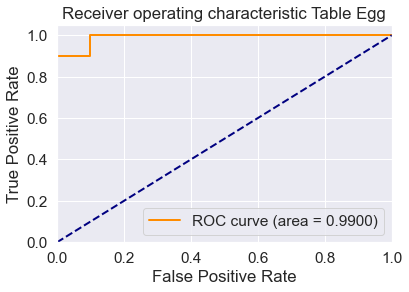

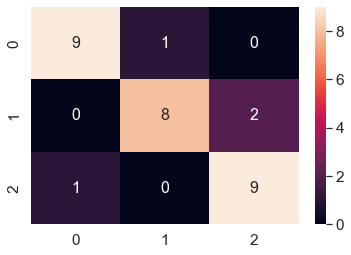


fold 3metrics:
Accuracy: 0.900000
Precision: 0.907407
Recall: 0.900000
F1 score: 0.899522


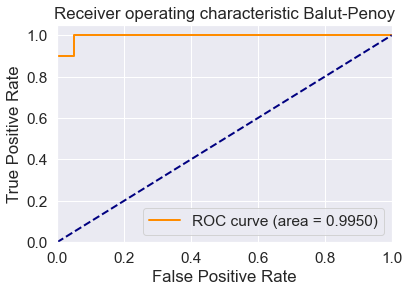

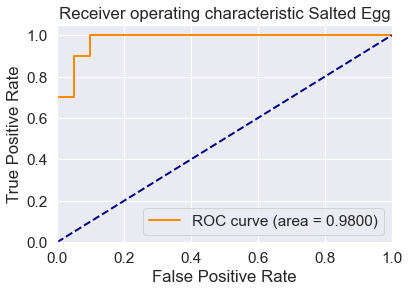

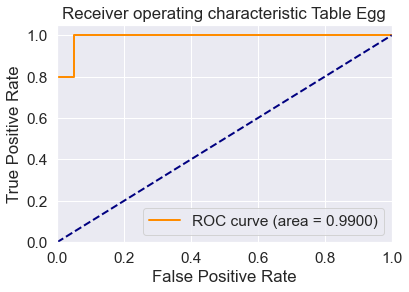

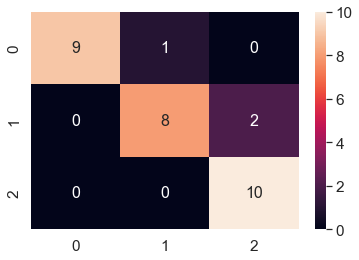


fold 4metrics:
Accuracy: 0.900000
Precision: 0.907407
Recall: 0.900000
F1 score: 0.899522


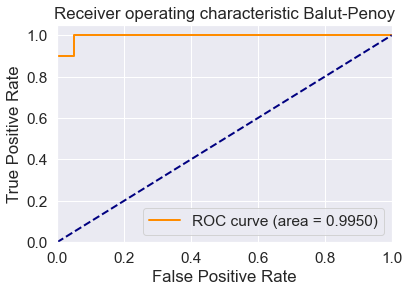

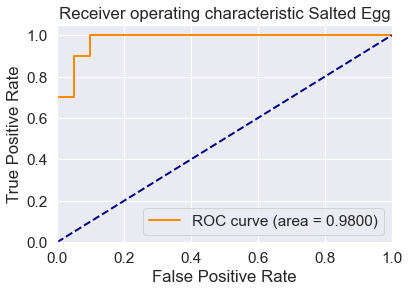

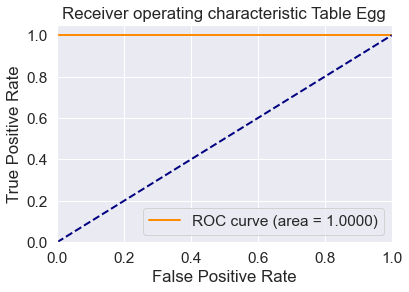

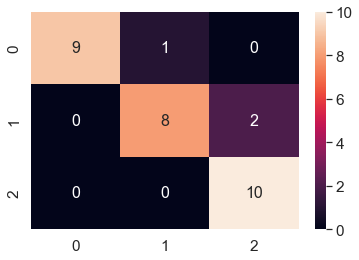


fold 5metrics:
Accuracy: 0.900000
Precision: 0.907407
Recall: 0.900000
F1 score: 0.899522


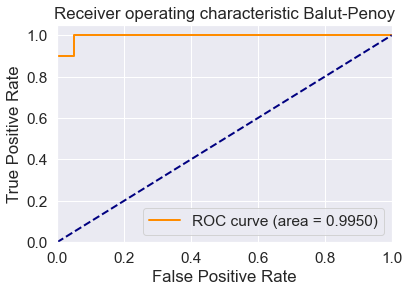

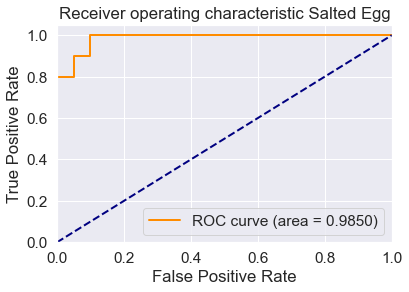

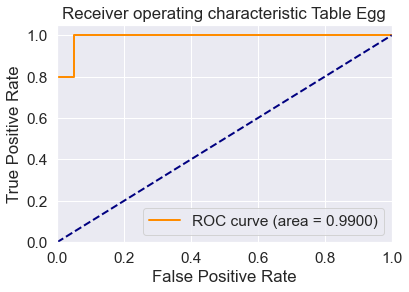

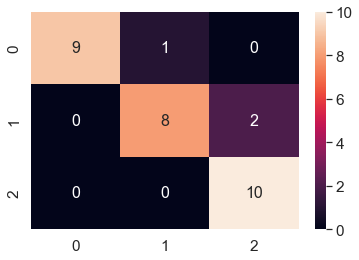

In [40]:
fold = 5
model = "saved_models_2"
for fold_num in range(fold):
    #load the weights of bet model
    model_dir = gen_dir + "/"+model+"/model_"+str(fold_num+1)+".h5"
    full_model.load_weights(model_dir)

    test_set = directory + "/ToBeUsed/test_set"

    testX = []

    for img_path in X_test['filename']:
        img = im.load_img(img_path, target_size=(224,224))
        x = im.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.reshape(224,224,3)
        testX.append(x)

    testX = np.array(testX)    

    # predict probabilities for test set, y_test
    yhat_probs = full_model.predict(testX, verbose=0)

    # predict crisp classes for test set
    yhat_classes = yhat_probs.argmax(axis=-1)
    
    print("fold "+str(fold_num+1) +"metrics:")
    eval(yhat_probs,yhat_classes)
    print('')

## Validating Misclassified Images

In [34]:
yhat_probs.shape, y_test.shape

((30, 3), (30, 1))

Note that we did a preprocessing on the images. We will use the image directories in the X_test and read it using cv2. This will convert the images into a numpy array. To convert back to its original rgb image form, we will use cv2.cvtColor.

In [35]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

Correct predictions

Found 27 correct labels


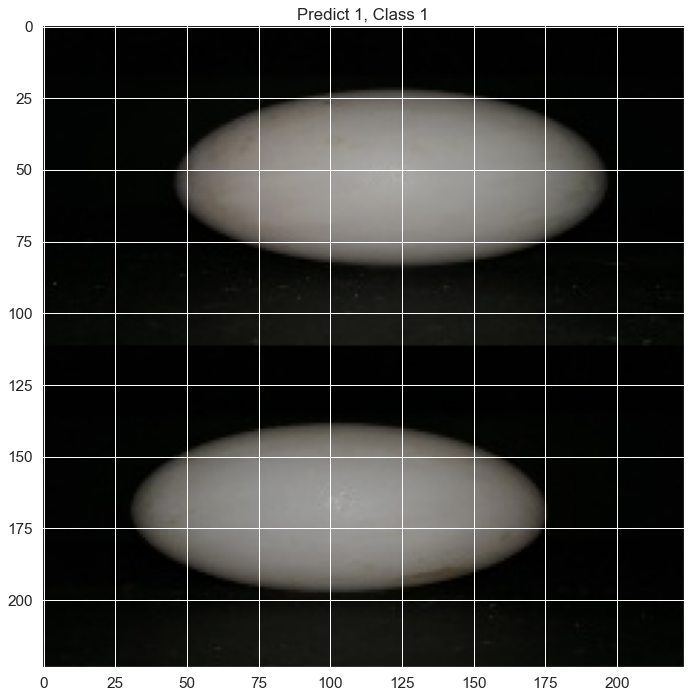

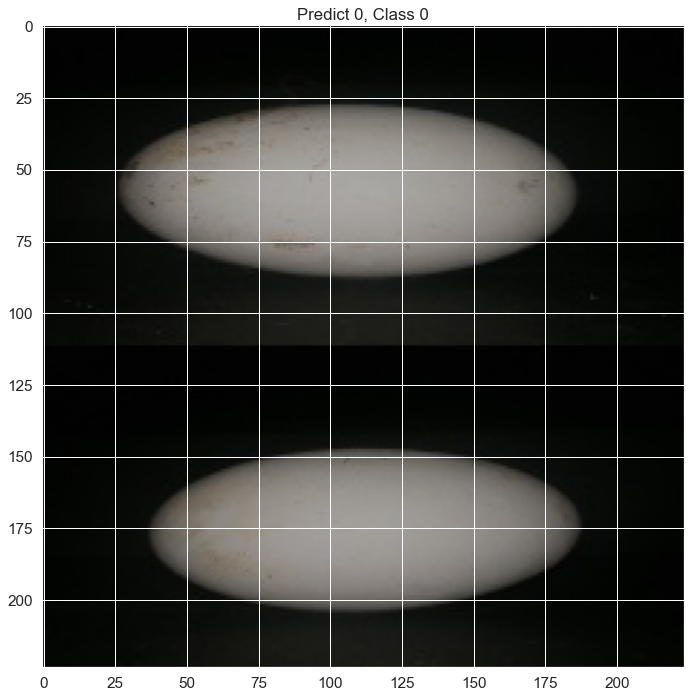

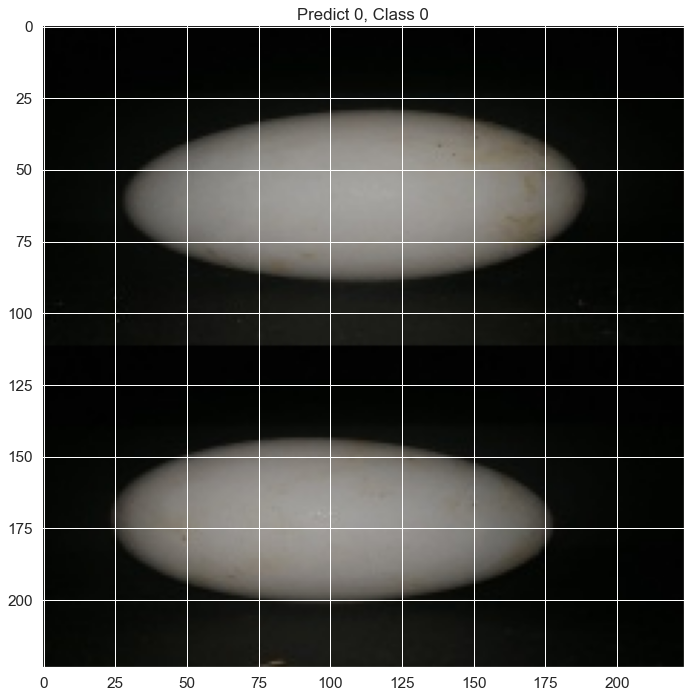

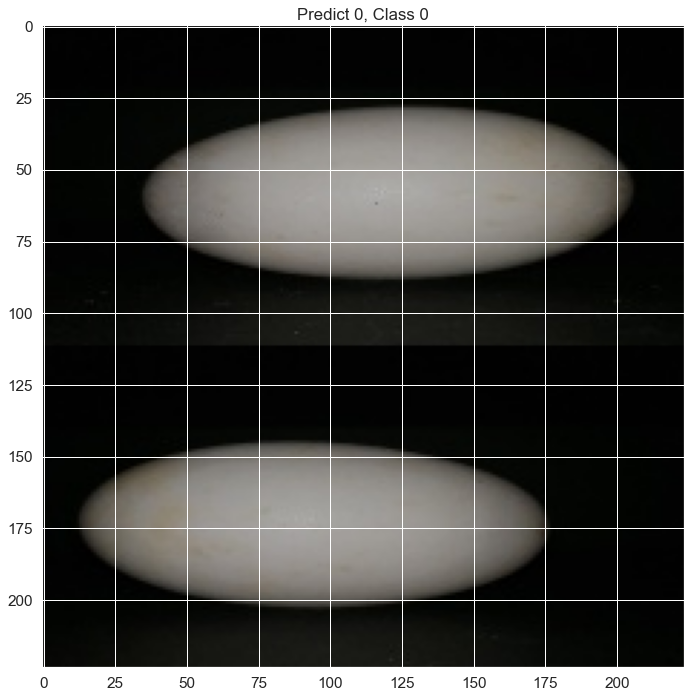

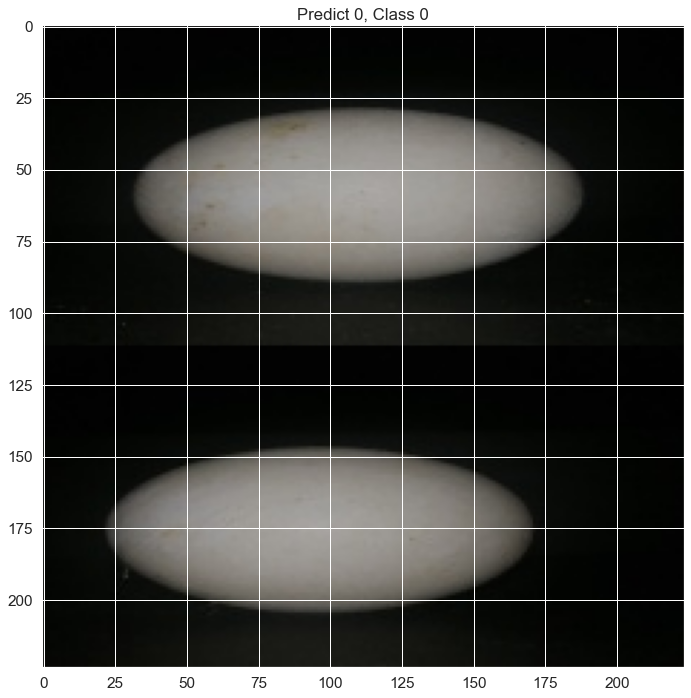

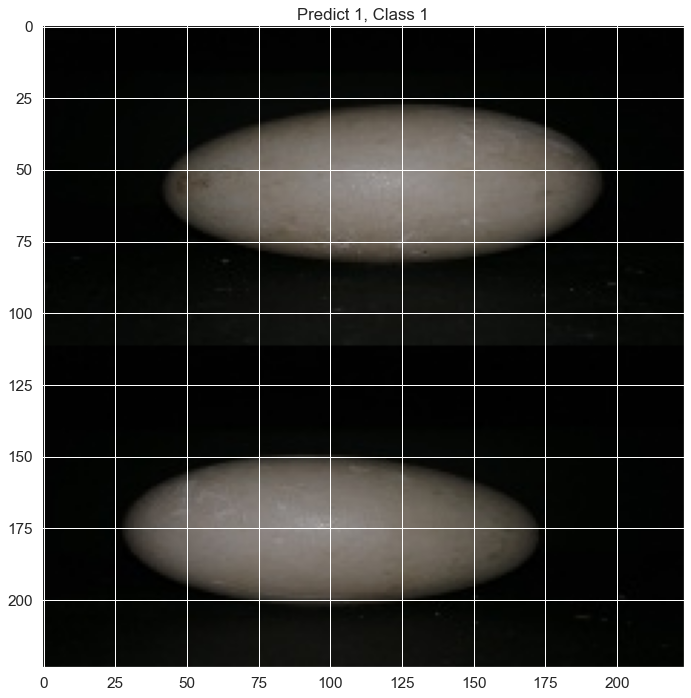

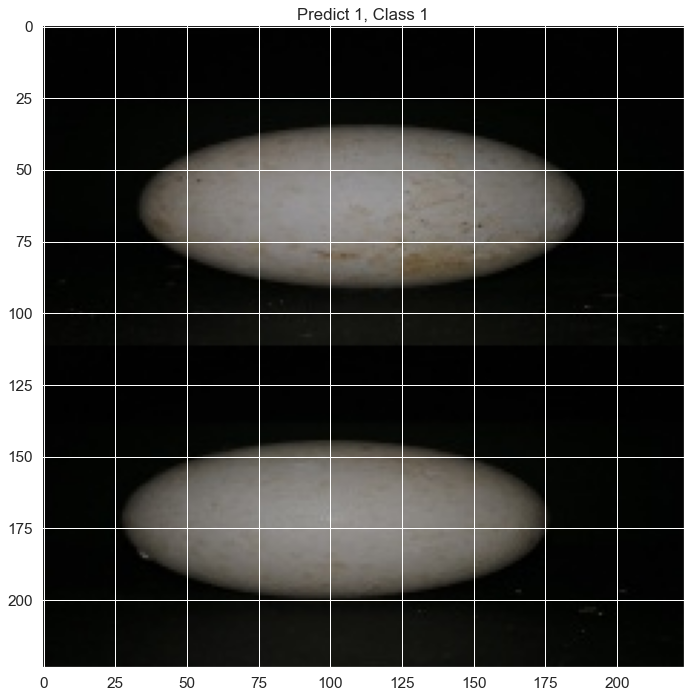

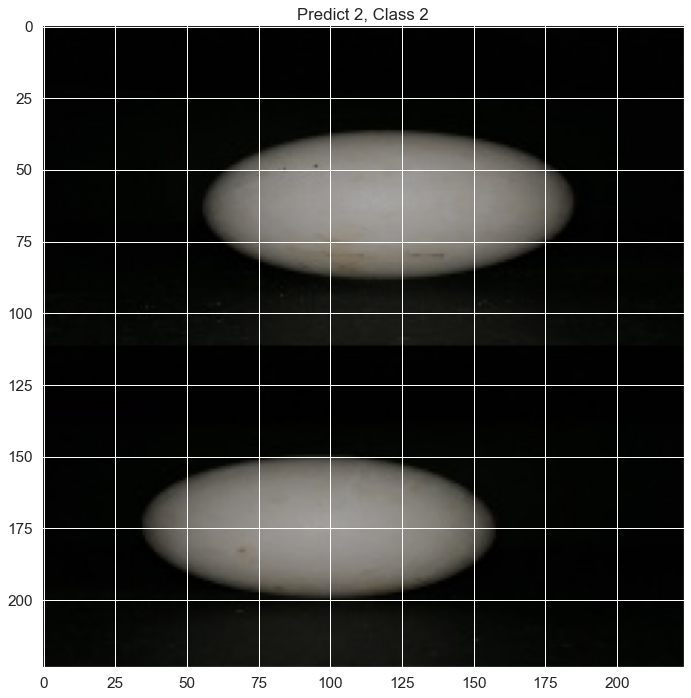

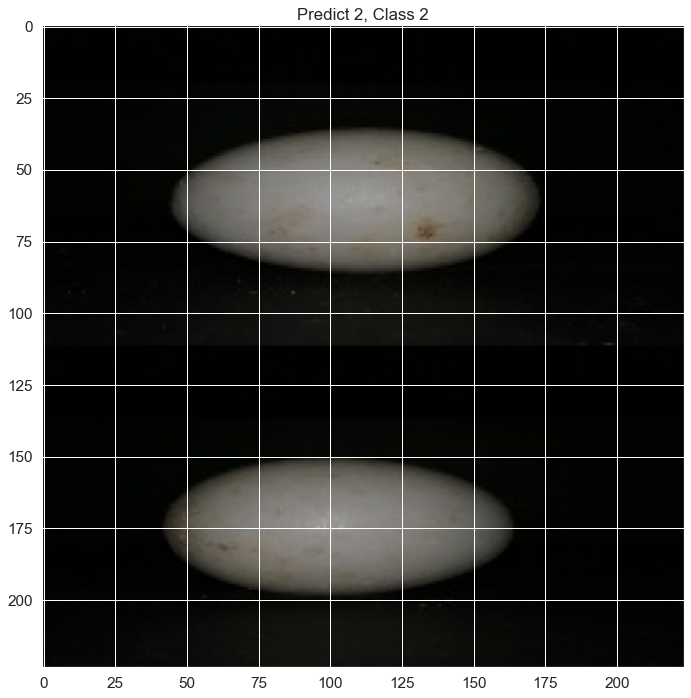

In [37]:
correct = np.where(yhat_classes==yt)[0]

print ("Found %d correct labels" % len(correct))

for i, correct in enumerate(correct[:9]):
    plt.figure(figsize=(10,10))
    #plt.subplot(3,3,i+1)
    RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='nearest') #, cmap='gray')
    plt.title("Predict {0}, Class {1}".format(str(yhat_classes[correct]),str(yt.values[correct])))
    plt.tight_layout()

Incorrect predictions

Found 3 incorrect labels


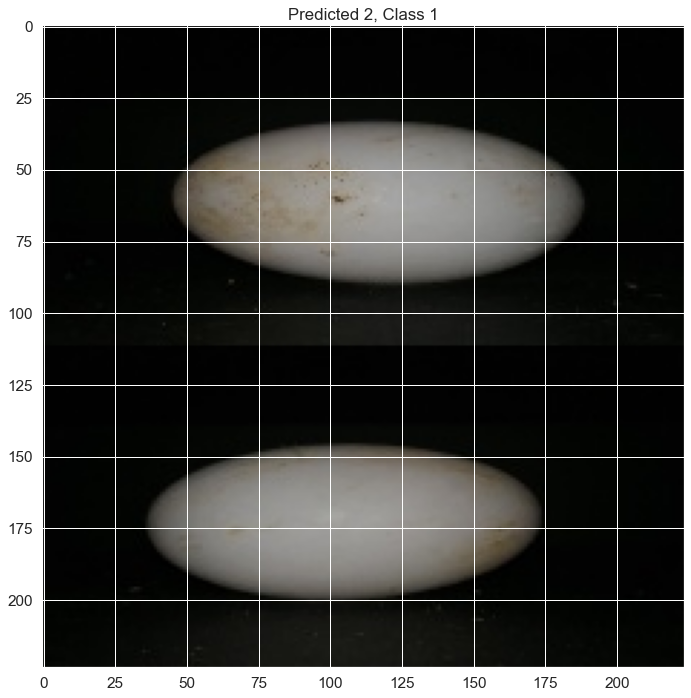

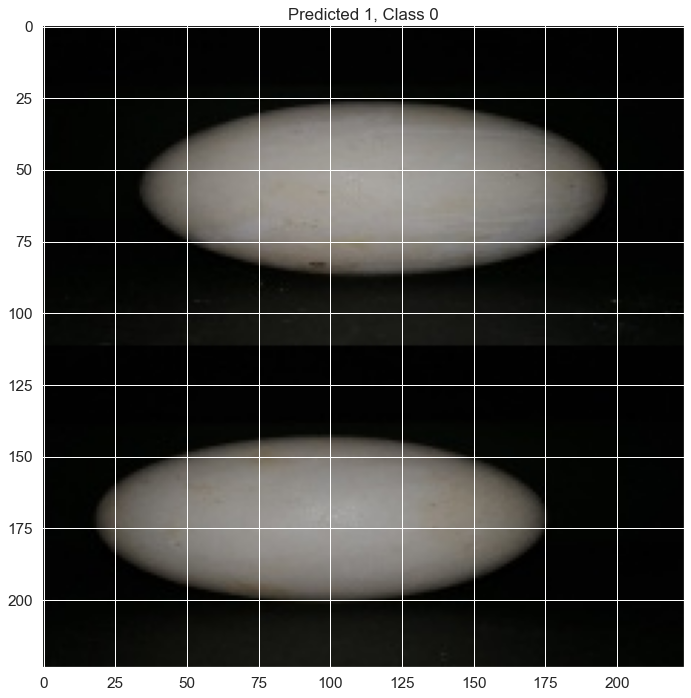

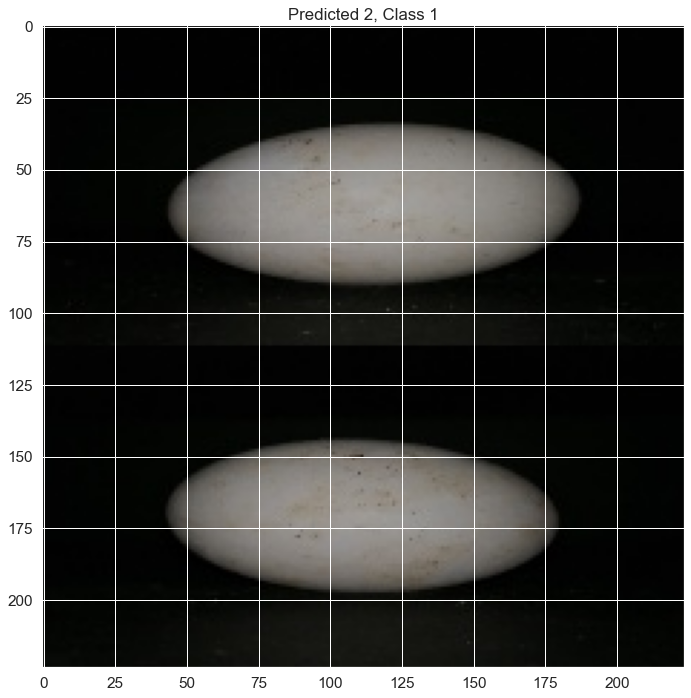

In [36]:
incorrect = np.where(yhat_classes!=yt)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.figure(figsize=(10,10))
    #plt.subplot(3,3,i+1)
    RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='nearest') #, cmap='gray')
    plt.title("Predicted {0}, Class {1}".format(str(yhat_classes[incorrect]), str(yt.values[incorrect])))
    plt.tight_layout()